<a href="https://colab.research.google.com/github/tystys17/blip/blob/main/BLIP-2/Chat_with_BLIP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chat with BLIP-2

In this notebook, we'll illustrate usage of BLIP-2, a state-of-the-art vision-language model by Salesforce.

HuggingFace docs: https://huggingface.co/docs/transformers/main/en/model_doc/blip_2.

## Set-up environment

We'll start by installing 🤗 Transformers. As the model is brand new at the time of writing this notebook, we install it from source.

Note that it's advised to run this notebook on a GPU environment, high RAM.

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Load image

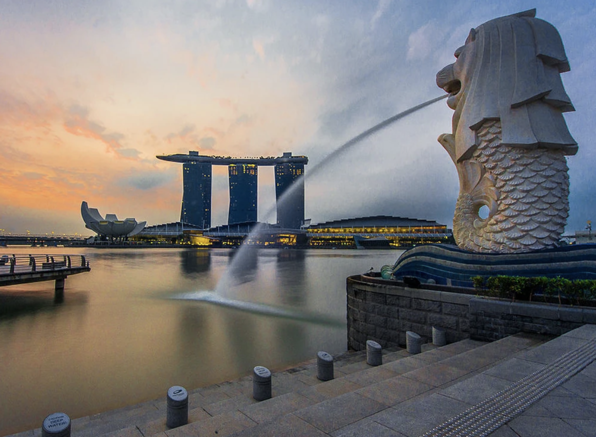

In [3]:
import requests
from PIL import Image

url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/assets/merlion.png' 
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')   
display(image.resize((596, 437)))

## Load model and processor

We can instantiate the model and its corresponding processor from the [hub](https://huggingface.co/models?other=blip-2). Here we load a BLIP-2 checkpoint that leverages the pre-trained OPT model by Meta AI, which as 2.7 billion parameters.

In [12]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration,BlipForQuestionAnswering,BlipProcessor
import torch

# processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
# # by default `from_pretrained` loads the weights in float32
# # we load in float16 instead to save memory
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16) 

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-capfilt-large")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-capfilt-large")

Let's use the GPU, as it will make generation a lot faster.

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [ ]:
from google.colab import files
from io import BytesIO
from PIL import Image
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return uploaded

In [ ]:
upload_file=upload_files()

Saving Screenshot from 2023-05-05 01-21-48.png to Screenshot from 2023-05-05 01-21-48.png


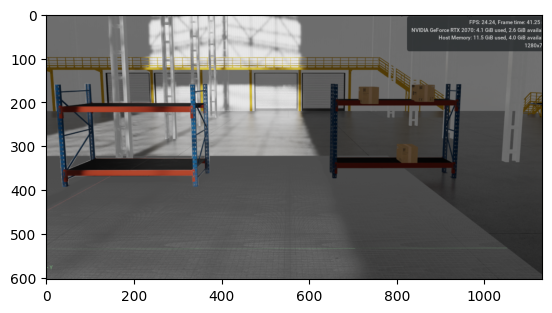

In [ ]:
import matplotlib.pyplot as plt
im = Image.open(BytesIO(upload_file['Screenshot from 2023-05-05 01-21-48.png']))
plt.imshow(im)

## Image captioning

If you don't provide any text prompt, then the model will by default start generating text from the BOS (beginning-of-sequence) token. So it will generate a caption for the image.

In [ ]:
inputs = processor(image, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

## Prompted image captioning

You can provide a text prompt, which the model will continue given the image.

In [ ]:
prompt = "this is a picture of"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

In [ ]:
prompt = "the weather looks"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

## Visual question answering (VQA)

In [ ]:
prompt = "Question: which city is this? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

## Chat-based prompting

We can create a ChatGPT-like interface by simply concatenating each generated response to the conversation. We prompt the model with some text (like "which city is this?"), the model generates an answer for it "Singapore"), which we just concatenate to the conversation. Then we ask a follow-up question ("why?") which we also just concatenate and feed to the model.

This means that the context can't be too long - models like OPT and T5 (the language models being used in BLIP-2) have a context length of 512 tokens.

In [ ]:
context = [
    ("which city is this?", "singapore"),
    ("why?", "it has a statue of a merlion"),
]
question = "where is the name merlion coming from?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

In [ ]:
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)